In [1]:
import scipy.io
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.metrics import mean_squared_error

In [2]:
mat = scipy.io.loadmat('Xtrain.mat')
data = mat['Xtrain']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 800 for train, 200 for test
train_data = scaled_data[:800]
test_data = scaled_data[800:]

predict_length = 200

In [3]:
def train(ws,verbose=0):
    window_size = ws  # number of past steps to use

    X, y = [], []
    for i in range(window_size,len(train_data) - window_size - predict_length + 1):
        X.append(train_data[i-window_size:i])
        y.append(train_data[i])
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(window_size, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')

    model.fit(X, y, epochs=20, batch_size=32,verbose=verbose)

    return model

In [6]:
def test(ws,model,verbose=0):
    window_size = ws
    # Predicting next 200 values 1 value at a time
    current_seq = train_data[-window_size:].flatten().tolist()
    predictions = []

    for _ in range(window_size,len(test_data)):
        input_seq = np.array(current_seq[-window_size:]).reshape(1, window_size, 1)
        next_pred = model.predict(input_seq,verbose=verbose)[0][0]
        predictions.append(next_pred)
        current_seq.append(next_pred)

    # print("Predicted next 200 values:")
    # print(predictions)

    true_test = test_data[window_size:].flatten()
    predicted = np.clip(np.array(predictions).flatten(),-10000,10000)

    return true_test, predicted


def evaluate(true_test: np.ndarray,predicted:np.ndarray,window_size: int):
    mse = mean_squared_error(true_test, predicted)
    print(f"windows size {window_size} -> Mean Squared Error:", mse)

    plt.figure(figsize=(20,3))
    plt.ylim((0,1))
    plt.title(f"WS: {window_size}. MSE: {mse}")
    plt.plot(true_test,c='green')
    plt.plot(predicted)

    SE = (predicted - true_test) ** 2
    plt.plot(SE,c='pink')
    plt.savefig(f"results/prediction ws{window_size}.png")

    return {"window_size":window_size,"mse":mse}

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


windows size 1 -> Mean Squared Error: 0.03133872089465609


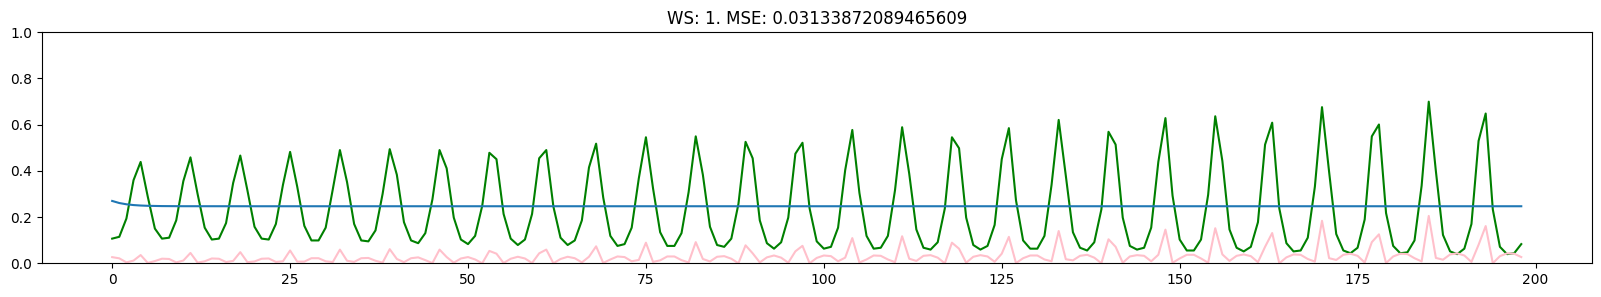

In [7]:
results = []

min_window_size = 1
max_window_size = 100

for i in range(min_window_size,max_window_size):
    ws = i
    model = train(ws,0)
    true_test,predicted = test(ws,model,0)
    res = evaluate(true_test,predicted, ws)
    results.append(res)
    break

In [26]:
results_df = pd.DataFrame(results)
results_df.to_csv("RNN_testingresults.csv")
results_df[results_df['mse']<0.035].sort_values(by='mse')

,window_size,mse
22,23,0.020497
28,29,0.022270
63,64,0.023320
79,80,0.023979
56,57,0.025953
14,15,0.030734
71,72,0.031098
27,28,0.032148
29,30,0.033413
34,35,0.033741


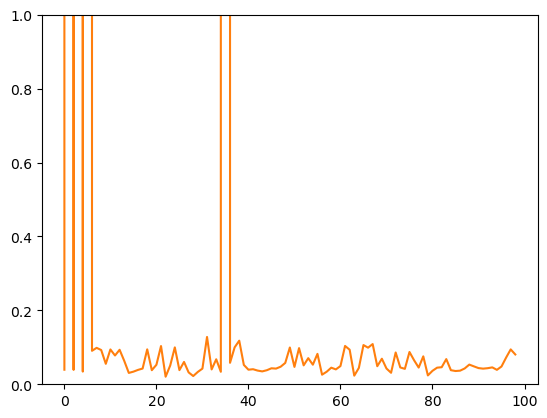

In [18]:
plt.ylim((0,1))
plt.plot(results_df)

In [30]:
results[49]

{'window_size': 50, 'mse': 0.03087220625339162}